In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open("../out/cifar10_summary.pkl", "rb") as f:
    out = pickle.load(f)

In [4]:
out.keys()

dict_keys(['mask', 'acc_train', 'acc_test', 'acc_test_new', 'mem_score', 'idx', 'infl_score_test', 'infl_score_testnew'])

First, look at the overall training and test accuracies

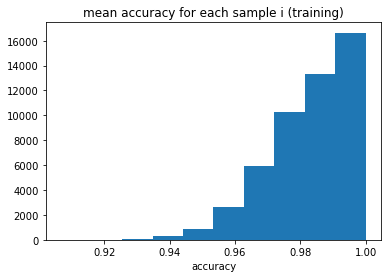

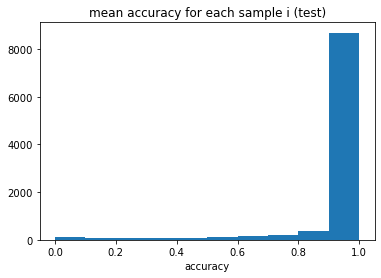

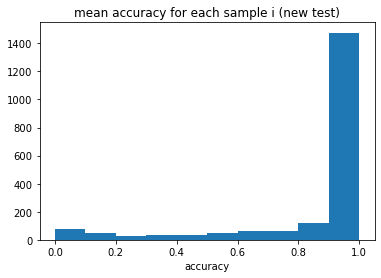

In [9]:
plt.hist(out["acc_train"].mean(axis = 0))
plt.xlabel("accuracy")
plt.title("mean accuracy for each sample i (training)")
plt.show()

plt.hist(out["acc_test"].mean(axis = 0))
plt.xlabel("accuracy")
plt.title("mean accuracy for each sample i (test)")
plt.show()

plt.hist(out["acc_test_new"].mean(axis = 0))
plt.xlabel("accuracy")
plt.title("mean accuracy for each sample i (new test)")
plt.show()

Next, look at the memory score

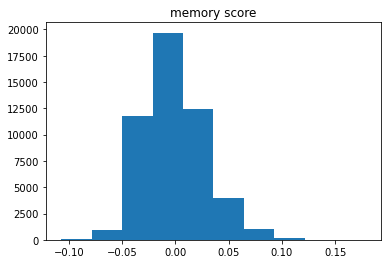

In [10]:
plt.hist(out['mem_score'])
plt.title("memory score")
plt.show()

In [11]:
## todo: look at those witth high memory

We pick the top samples with the 1% memory score, and compute their influence on the test and new-test data

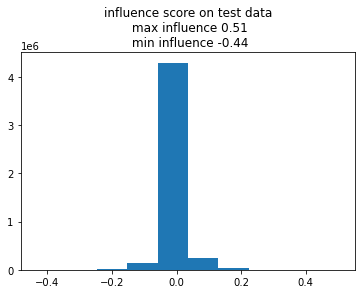

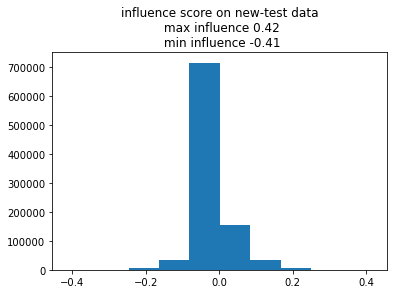

In [18]:
plt.hist(out['infl_score_test'].flatten())
plt.title(f"influence score on test data\n \
max influence {out['infl_score_test'].max().round(2)}\n \
min influence {out['infl_score_test'].min().round(2)}")
plt.show()

plt.hist(out['infl_score_testnew'].flatten())
plt.title(f"influence score on new-test data\n \
max influence {out['infl_score_testnew'].max().round(2)}\n \
min influence {out['infl_score_testnew'].min().round(2)}")
plt.show()